<a href="https://www.kaggle.com/code/danuherath/titanic-survival-classification?scriptVersionId=187140874" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center"> Titanic Disaster Survival Prediction (Binary Classification) </h1>

<img 
    src="https://www.kaggle.com/competitions/3136/images/header" 
    alt="" 
    width="500" 
    height="400" 
    style="display: block; margin: 0 auto; border-radius:15px" 
/>

---

## Problem Definition

- Dataset

    - [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/data?select=train.csv) Dataset from Kaggle which contains 10 features explaining passengers' demographics, cruise details etc. Train dataset contains 891 samples and each instance represents one passenger.

<br>

- Objective
    - The goal of this project is to predict whether a passenger survived the Titanic disaster based on the above features.

<br>

- Following classification algorithms are used to train models. The models are evaluated using the accuracy score.
- Top scoring models are used for hyperparameter tuning and training a [stacking classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) and a [voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).

    1. [Logistic Regression Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
    2. [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
    3. [K-Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
    4. [Gaussian Naive Bayes Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
    5. [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
    6. [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
    7. [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)
    8. [Adaboost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
    9. [Neural Network](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')


In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')


In [3]:
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S



---

# Step 1: Exploratory Data Analysis (EDA)¶

---


## Data Dictionary:

| Variable | Definition | Key |
|----------|----------|----------|
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Gender |  |
| Age | Age in years |  |
| sibsp | # of siblings/ spouses aboard the Titanic |  |
| parch | # of parents / children aboard the Titanic |  |
| ticket | Ticket number |  |
| fare | Passenger fare |  |
| cabin | Cabin number |  |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |


## Variable Notes:
* pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower
* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
* sibsp: The dataset defines family relations in this way
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)
* parch: The dataset defines family relations in this way
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them.


In [5]:
train_data.shape


(891, 12)

In [6]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_data.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
train_data.nunique()


PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [9]:
train_data.drop('PassengerId', axis=1).duplicated().sum()


0

In [10]:
train_data.dtypes


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
train_data.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
cat_features = ['Pclass', 'Sex', 'Embarked']
num_features = ['Age', 'Fare', 'SibSp', 'Parch']
unimportant_features = ['PassengerId', 'Name', 'Ticket', 'Cabin']
target = ['Survived']


In [13]:
train_data[cat_features].dtypes


Pclass       int64
Sex         object
Embarked    object
dtype: object

In [14]:
train_data[num_features].dtypes


Age      float64
Fare     float64
SibSp      int64
Parch      int64
dtype: object

In [15]:
train_data[target].value_counts()


Survived
0           549
1           342
Name: count, dtype: int64

## 1.1 Statistical Analysis


In [16]:
train_data[num_features].describe()


,Age,Fare,SibSp,Parch
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.523008,0.381594
std,14.526497,49.693429,1.102743,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000
75%,38.000000,31.000000,1.000000,0.000000
max,80.000000,512.329200,8.000000,6.000000


In [17]:
Q1 = train_data[num_features].quantile(0.25)
Q3 = train_data[num_features].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((train_data[num_features] < lower_bound) | (train_data[num_features] > upper_bound))

outliers_count = outliers_iqr.sum()
outliers_count = outliers_count[outliers_count > 0].sort_values(ascending=False)
print(f"Outliers Count: \n{outliers_count}")


Outliers Count: 
Parch    213
Fare     116
SibSp     46
Age       11
dtype: int64


## 1.2 Data Visualization


### 1.2.1 Univariate Analysis


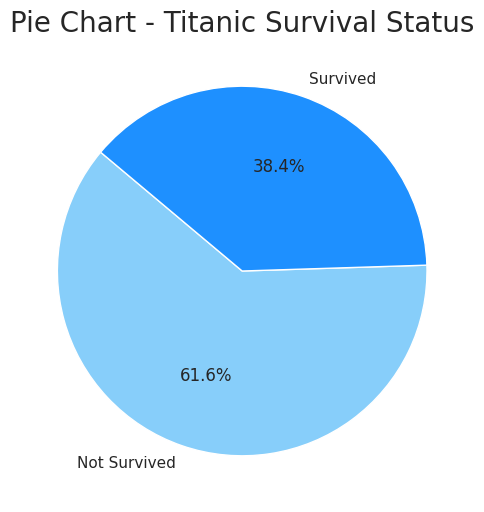

In [18]:
value_counts = train_data[target].value_counts()

sns.set_theme()
plt.figure(figsize=(8, 6))
palette = ['lightskyblue', 'dodgerblue']

plt.pie(value_counts, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', startangle=140, colors=palette)
plt.title('Pie Chart - Titanic Survival Status', fontsize=20)

plt.savefig('Pie Chart - Titanic Survival Status.png')
plt.show()


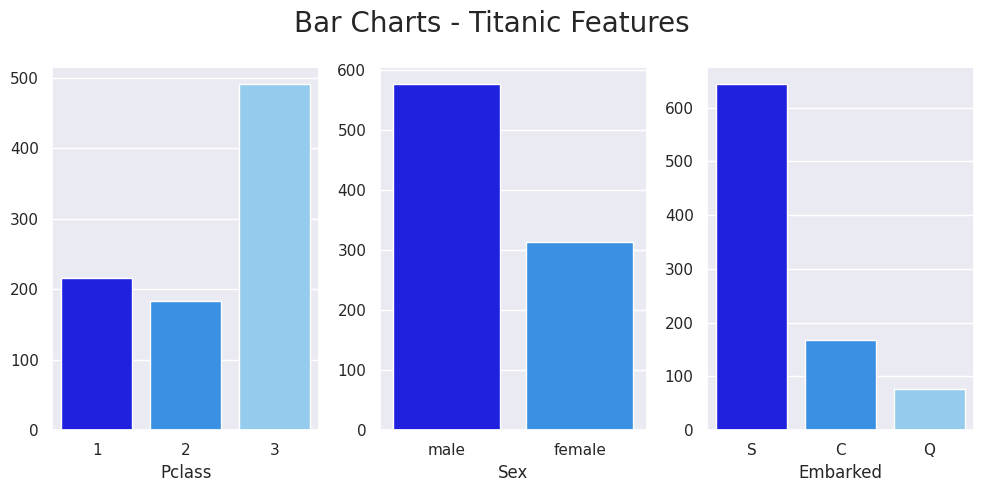

In [19]:
n_rows = 1
n_cols = 3
palette = ['blue', 'dodgerblue', 'lightskyblue']

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5*n_rows))
fig.tight_layout(pad=4.0)

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    category_counts = train_data[cat_features][column].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, palette=palette)


plt.suptitle('Bar Charts - Titanic Features', fontsize=20)
plt.tight_layout()

plt.savefig('Bar Charts - Titanic Features')
plt.show()


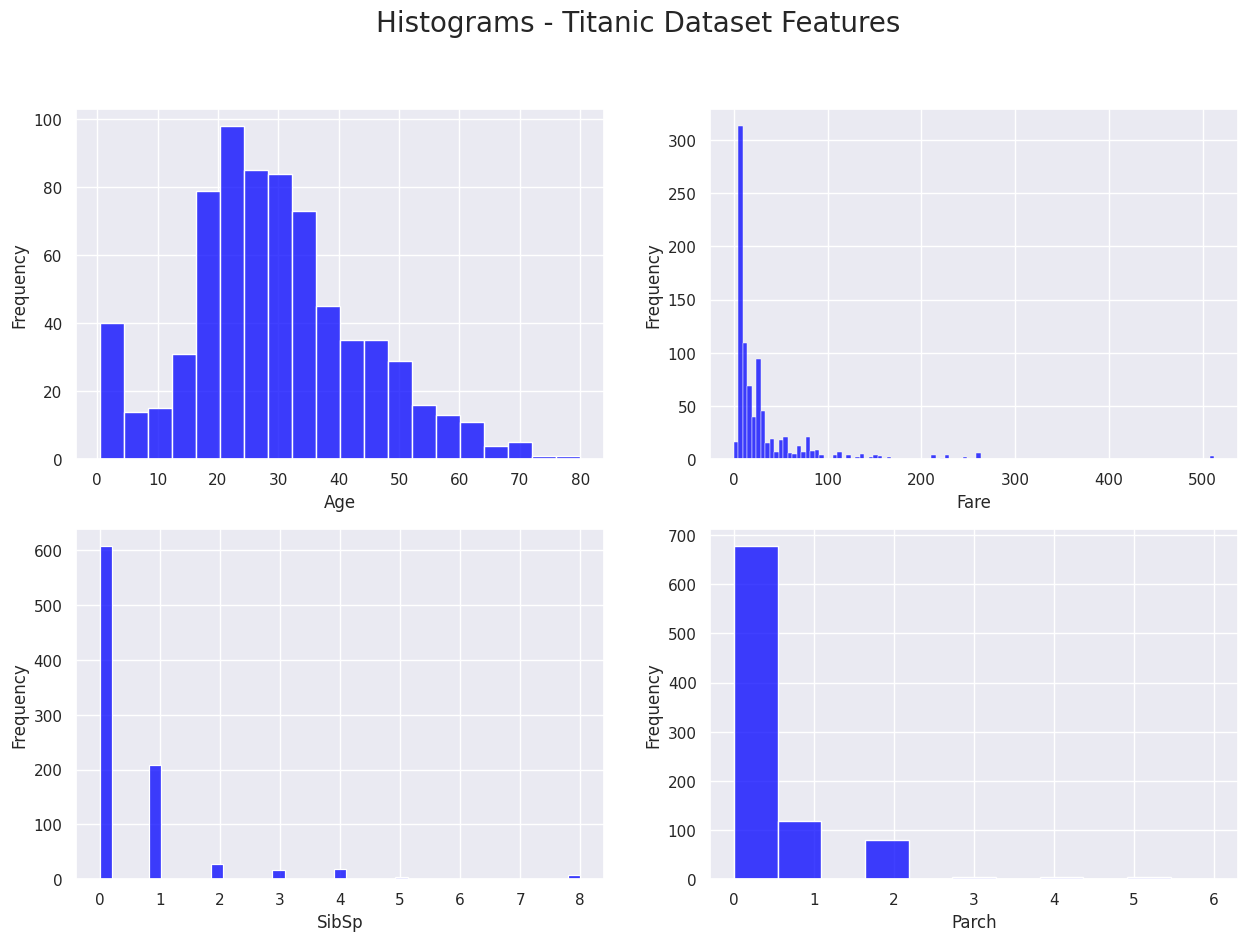

In [20]:
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()


for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.histplot(train_data[num_features][col], ax=ax, color='blue')
    ax.set_ylabel('Frequency')

plt.suptitle('Histograms - Titanic Dataset Features', fontsize=20)

plt.savefig('Histograms - Titanic Dataset Features.png')
plt.show()


### 1.2.2 Bivariate Analysis


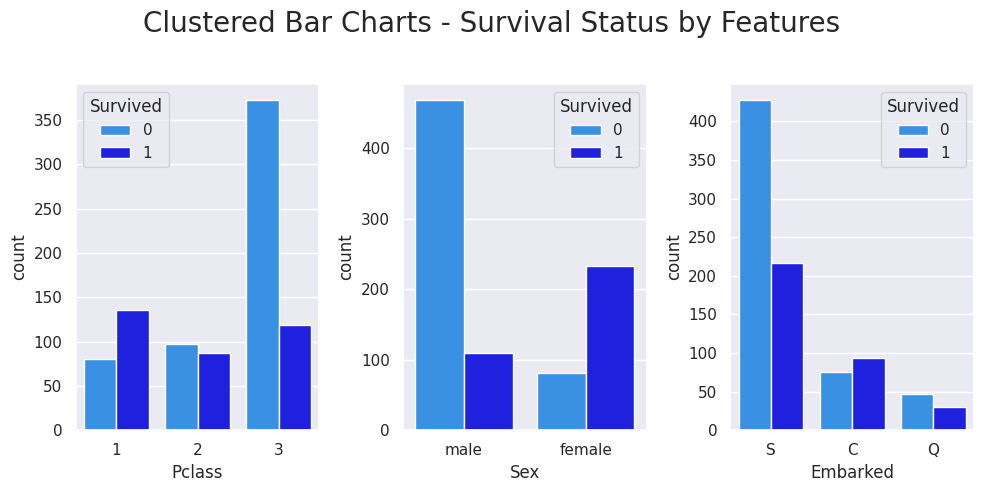

In [21]:
n_rows = 1
n_cols = 3
palette = ['dodgerblue', 'blue']

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5*n_rows))
fig.tight_layout(pad=4.0)

for i, column in enumerate(cat_features):
    ax = axes[i]
    sns.countplot(data=train_data, x=column, hue='Survived', palette=palette, ax=ax)

plt.suptitle('Clustered Bar Charts - Survival Status by Features', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('Clustered Bar Charts - Titanic Features.png')
plt.show()


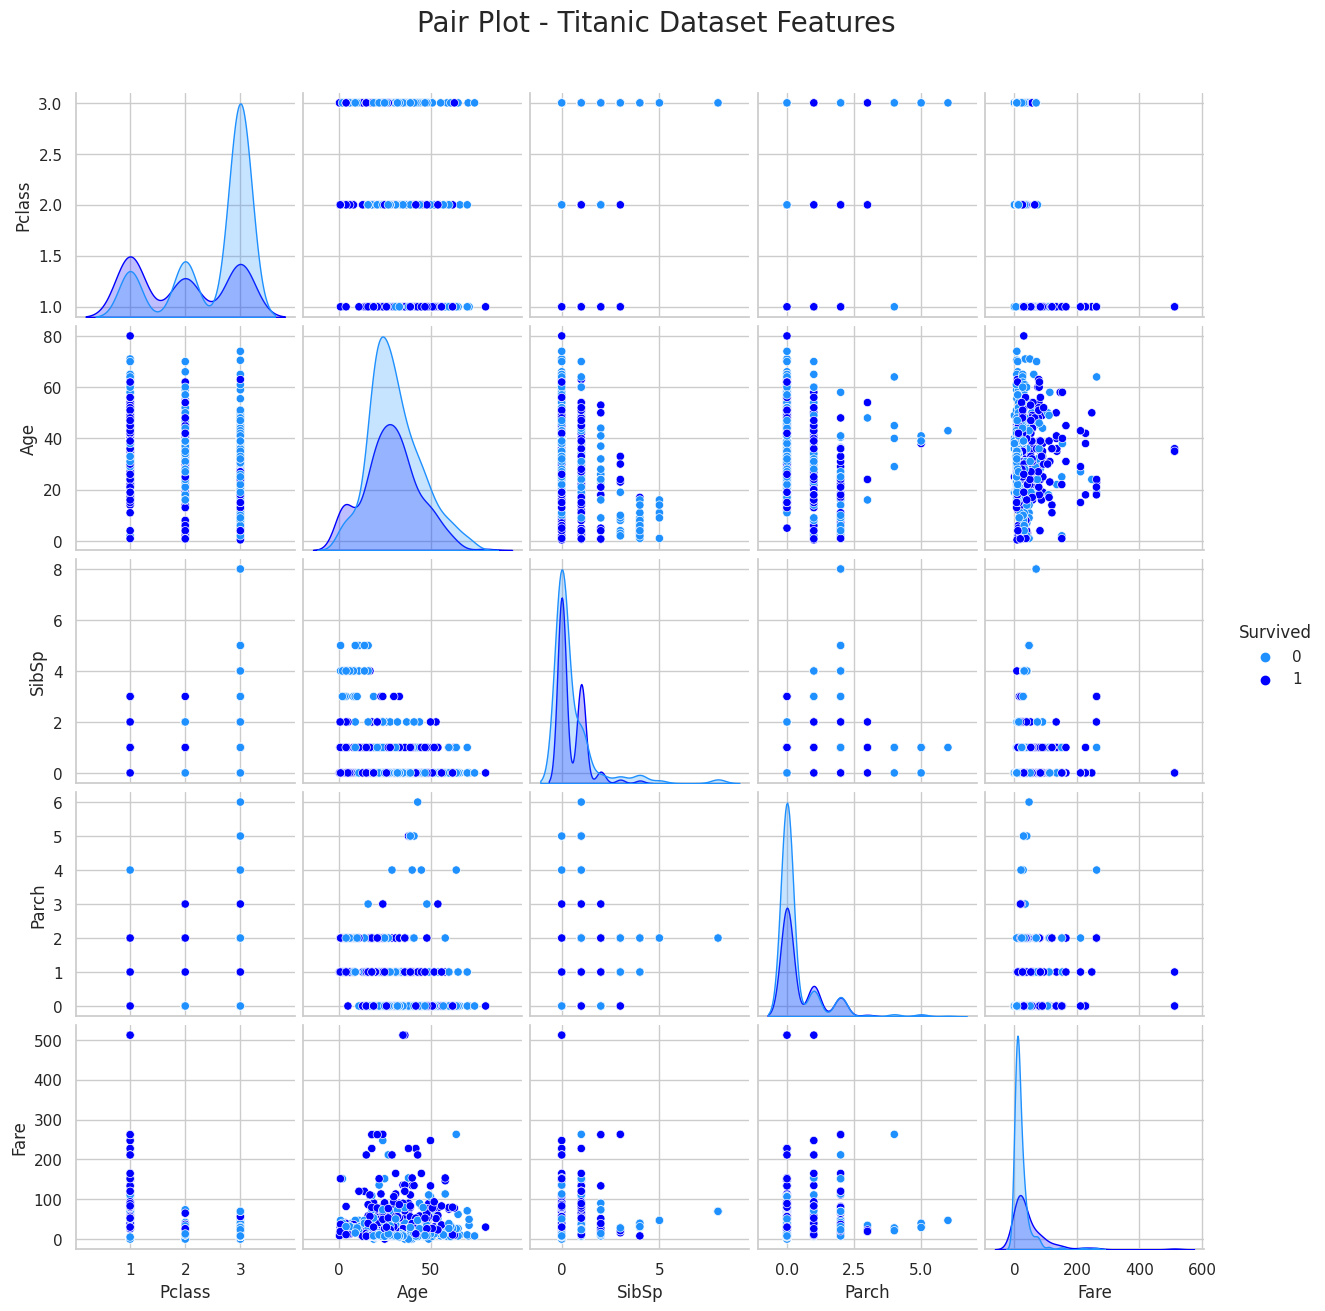

In [22]:
sns.set(style="whitegrid")
palette = ['dodgerblue', 'blue']
data = train_data.drop(['PassengerId'], axis=1)

sns.pairplot(data, hue='Survived', palette=palette)
plt.suptitle('Pair Plot - Titanic Dataset Features', y=1.05, fontsize=20)

plt.savefig('Pair Plot - Titanic Dataset Features.png')
plt.show()


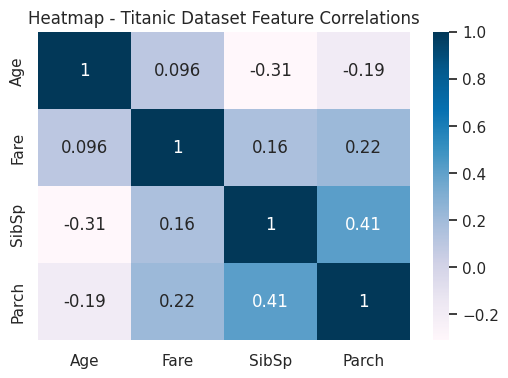

In [23]:
corr = train_data[num_features].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='PuBu')
plt.title('Heatmap - Titanic Dataset Feature Correlations')

plt.savefig('Titanic Dataset Feature Correlations.png')
plt.show()


### Conclusion:¶

* No duplicated rows are prsent
* No inconsistent labels in the Target column
* 'Age', 'Cabin', 'Embarked' columns have null values
* 'Age', 'SibSp', 'Parch', 'Fare' features contain numerical data
* 'Pclass', 'Sex', 'Embarked' features contain categorical data
* 'PassengerId', 'Name', 'Ticket' features are not important for model training
* 'Age', 'SibSp', 'Parch', 'Fare' features has outliers

<br>



---

# Step 2. Data Cleaning & Feature Engineering

---


In [24]:
train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)


In [25]:
# Add new feature 'Family' summing up 'Sibsp' and 'Parch' features
train_data['Family'] = train_data['SibSp'] + train_data['Parch']
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
train_data.head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [26]:
test_data['Family'] = test_data['SibSp'] + test_data['Parch']
test_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_data.head()


,Pclass,Sex,Age,Fare,Embarked,Family
0,3,male,34.5,7.8292,Q,0
1,3,female,47.0,7.0000,S,1
2,2,male,62.0,9.6875,Q,0
3,3,male,27.0,8.6625,S,0
4,3,female,22.0,12.2875,S,2



---

# Step 3. Data Pre-processing

---


In [27]:
train_data['Pclass'] = pd.Categorical(train_data['Pclass'], ordered=True)
train_data['Sex'] = pd.Categorical(train_data['Sex'])
train_data['Embarked'] = pd.Categorical(train_data['Pclass'])
train_data['Survived'] = pd.Categorical(train_data['Survived'])
train_data.dtypes


Survived    category
Pclass      category
Sex         category
Age          float64
Fare         float64
Embarked    category
Family         int64
dtype: object

In [28]:
numerical_cols = ['Age', 'Fare', 'Family']
categorical_cols = ['Sex', 'Embarked']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_cols)
    ],
    remainder='passthrough'
)


In [29]:
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']



--- 

# Step 4. Model Training & Evaluation

---


In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# models = {
#     'Logistic Regression': LogisticRegression(),
#     'Support Vector Machine': SVC(),
#     'K-Nearest Neighbors': KNeighborsClassifier(),
#     'Naive Bayes': GaussianNB(),
#     'Decision Tree': DecisionTreeClassifier(random_state=42),
#     'Random Forest': RandomForestClassifier(random_state=42),
#     'Gradient Boosting': GradientBoostingClassifier(random_state=42),
#     'AdaBoost': AdaBoostClassifier(random_state=42),
#     'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
# }


In [ ]:
# def train_models(X_train, X_val, y_train, y_val, models, preprocessor):
#     results = {}

#     for name, model in models.items():
#         pipeline = Pipeline(steps=[
#             ('preprocessor', preprocessor),
#             ('model', model)
#         ])

#         pipeline.fit(X_train, y_train)

#         y_pred = pipeline.predict(X_val)

#         print(f'Classification Report for {name}:')
#         print(classification_report(y_val, y_pred))
#         print('\n')

#         # results[name] = classification_report(y_val, y_pred, output_dict=True)

    
#     # return results


# train_models(X_train, X_val, y_train, y_val, models, preprocessor)


## 4.1 Hyperparameter Tuning


In [31]:
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', GradientBoostingClassifier(random_state=42))
# ])

# param_grid = {
#     'classifier__n_estimators': [50, 100, 150, 200],
#     'classifier__learning_rate': [0.01, 0.1, 0.5, 1.0],
#     'classifier__max_depth': [3, 5, 7, 9]
# }

# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='accuracy')

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-validation Accuracy:", grid_search.best_score_)

# best_gb_clf = grid_search.best_estimator_
# y_pred = best_gb_clf.predict(X_val)
# test_accuracy = accuracy_score(y_val, y_pred)
# print("Test Accuracy:", test_accuracy)


Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 150}
Best Cross-validation Accuracy: 0.8272691705790297
Test Accuracy: 0.8156424581005587


In [32]:
# # tune adaboost
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', AdaBoostClassifier(random_state=42))
# ])

# param_grid = {
#         'classifier__n_estimators': [50, 100, 200],
#         'classifier__learning_rate': [0.01, 0.1, 1.0]
# }

# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='accuracy')

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-validation Accuracy:", grid_search.best_score_)

# best_ab_clf = grid_search.best_estimator_
# y_pred = best_ab_clf.predict(X_val)
# test_accuracy = accuracy_score(y_val, y_pred)
# print("Test Accuracy:", test_accuracy)


Best Parameters: {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 200}
Best Cross-validation Accuracy: 0.8174295774647888
Test Accuracy: 0.8100558659217877


In [ ]:

# def objective(trial):
#     hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50)])
#     activation = trial.suggest_categorical('activation', ['tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['sgd', 'adam'])
#     alpha = trial.suggest_loguniform('alpha', 0.0001, 0.01)
#     learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])

#     clf = MLPClassifier(
#         hidden_layer_sizes=hidden_layer_sizes,
#         activation=activation,
#         solver=solver,
#         alpha=alpha,
#         learning_rate=learning_rate,
#         max_iter=1000,
#         random_state=42
#     )

#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('classifier', clf)
#     ])

#     scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
#     return scores.mean()


# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# best_params = study.best_params
# print("Best Parameters:", best_params)

# best_clf = MLPClassifier(
#     hidden_layer_sizes=best_params['hidden_layer_sizes'],
#     activation=best_params['activation'],
#     solver=best_params['solver'],
#     alpha=best_params['alpha'],
#     learning_rate=best_params['learning_rate'],
#     max_iter=1000,
#     random_state=42
# )

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', best_clf)
# ])

# pipeline.fit(X_train, y_train)

# y_pred = pipeline.predict(X_val)
# test_accuracy = accuracy_score(y_val, y_pred)
# print("Test Accuracy:", test_accuracy)


In [40]:

# def train_stacking_classifier(X_train, y_train, X_val, y_val, preprocessor):
#     base_models = [
#         ('gb_clf', GradientBoostingClassifier(
#             random_state=42,
#             learning_rate=0.01,
#             max_depth=5,
#             n_estimators=150
#         )),
#         ('ab_clf', AdaBoostClassifier(
#             random_state=42,
#             learning_rate=1.0,
#             n_estimators=200
#         )),
#     ]
    
#     meta_model = LogisticRegression()
    
#     stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('classifier', stacking_clf)
#     ])

#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_val)
    
#     test_accuracy = accuracy_score(y_val, y_pred)
#     print("Stacking Classifier Test Accuracy:", test_accuracy)
    
#     return pipeline, stacking_clf


# stacking_pipeline, stacking_clf = train_stacking_classifier(X_train, y_train, X_val, y_val, preprocessor)


Stacking Classifier Test Accuracy: 0.8212290502793296


In [33]:

def train_voting_classifier(X_train, y_train, X_val, y_val, preprocessor):
    base_models = [
        ('gb_clf', GradientBoostingClassifier(
            random_state=42,
            learning_rate=0.01,
            max_depth=5,
            n_estimators=150
        )),
        ('ab_clf', AdaBoostClassifier(
            random_state=42,
            learning_rate=1.0,
            n_estimators=200
        )),
    ]
    
    voting_clf = VotingClassifier(estimators=base_models, voting='soft')
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', voting_clf)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    
    test_accuracy = accuracy_score(y_val, y_pred)
    print("Voting Classifier Test Accuracy:", test_accuracy)
    
    return pipeline, voting_clf


voting_pipeline, voting_clf = train_voting_classifier(X_train, y_train, X_val, y_val, preprocessor)


Voting Classifier Test Accuracy: 0.8156424581005587



---

# Step 5. Model Prediction on Test Data

---


In [34]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', voting_clf)
])

test_predictions = pipeline.predict(test_data)


In [35]:
submission = pd.read_csv('/kaggle/input/titanic/test.csv')
submission['Survived'] = test_predictions
submission = submission[['PassengerId', 'Survived']]

submission.to_csv('submission.csv', index=False)

submission.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
